# Machine Learning - Tarea 3
---

---

<div style="text-align: right">
Vicente Lizana - 201310004-K
</div>
<div style="text-align: right">
Álvaro Valderrama - 201390005-4
</div>

---

In [101]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn import utils as skut
from sklearn import model_selection as skms
from sklearn import tree as sktr
from sklearn import decomposition as skdc
from sklearn import preprocessing as skpp
from sklearn import svm as sksvm
from sklearn import model_selection as skms

from keras import models as krms
from keras import layers as krly
from keras import optimizers as kropt

---

---
## 1.- Small circle inside Large circle

---
### 1.a

#### Generación de Datos

In [2]:
def do_circles(n=2000,noisy_n=0.05):
    generator = skut.check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    
    X = np.vstack((
        np.append(outer_circ_x, inner_circ_x),
        np.append(outer_circ_y, inner_circ_y)
    )).T
    
    y = np.hstack([
        np.zeros(n // 2, dtype=np.intp),
        np.ones(n // 2, dtype=np.intp)
    ])
    
    X += generator.normal(scale=noisy_n, size=X.shape)
    X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = do_circles()

In [46]:
def plot_classifier(clf, X_train, Y_train, X_test, Y_test, model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(12, 8))
    axis.scatter(X_train[:,0], X_train[:,1], s=30, c=Y_train, zorder=10, cmap='cool')
    axis.scatter(X_test[:,0], X_test[:,1], s=20, c=Y_test, zorder=10, cmap='Greys')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else:
        raise ValueError('model type not supported')
        
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0.5
    axis.pcolormesh(XX, YY, Zplot, cmap='YlGn')
    axis.contour(XX, YY, Z, alpha=1, colors=["k", "k", "k"], linestyles=["--", "-", "--"], levels=[-2, 0, 2])
    plt.show()

---
### 1.b

#### Red con una sola neurona

In [39]:
n_h=1
model = krms.Sequential()
model.add(krly.Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(krly.Dense(n_h, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=kropt.SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
scores = model.evaluate(X_test, y_test)
test_acc = scores[1]

1000/1000 [==============================] - 0s 93us/step


In [22]:
print("Score over Test Set: {:>.3}".format(test_acc))

Score over Test Set: 0.669


/home/vlizana/u/machine-learning/v-temp/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


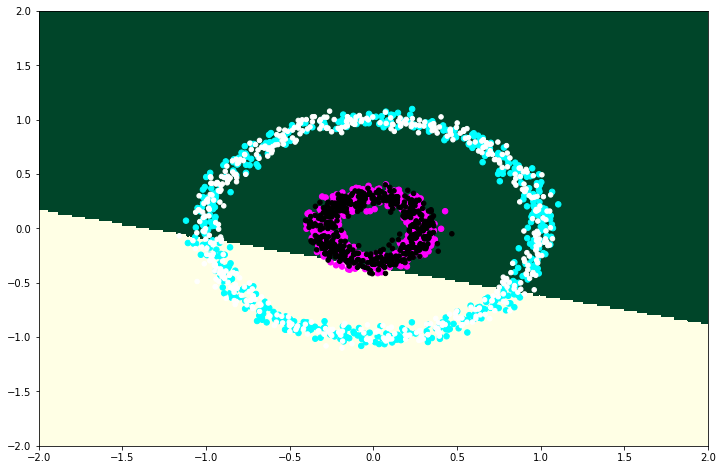

In [45]:
plot_classifier(model, X_train, y_train, X_test, y_test, 'ann')

---
### 1.c

#### Red con una _Hidden Layer_

In [38]:
n_h=32
model = krms.Sequential()
model.add(krly.Dense(n_h, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(krly.Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=kropt.SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=0)
scores = model.evaluate(X_test, y_test)
test_acc = scores[1]

1000/1000 [==============================] - 0s 111us/step


In [25]:
print(test_acc)

1.0


/home/vlizana/u/machine-learning/v-temp/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


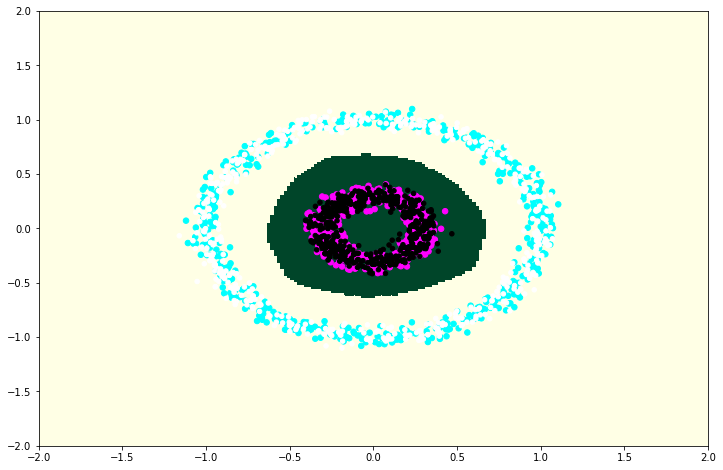

In [30]:
plot_classifier(model, X_train, y_train, X_test, y_test, 'ann')

---
### 1.d

#### placeholder

Test Accuracy = 0.67
1


/home/vlizana/u/machine-learning/v-temp/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


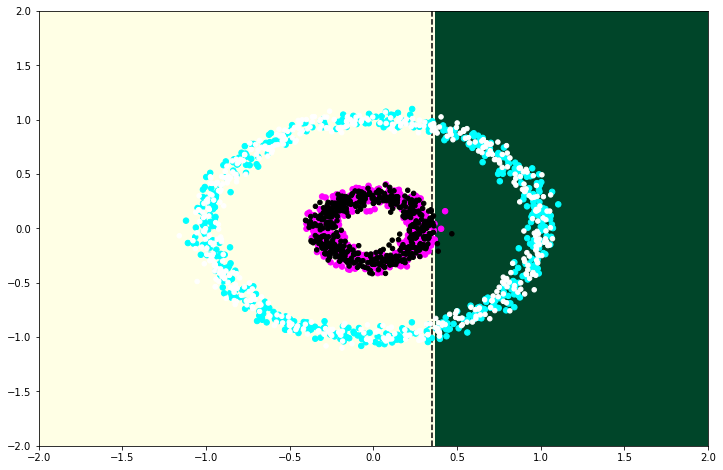

In [34]:
clf = sktr.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0, max_depth=1)
clf.fit(X_train,y_train)
acc_test = clf.score(X_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print(clf.tree_.max_depth)
plot_classifier(clf, X_train, y_train, X_test, y_test, 'tree')

---
### 1.e

#### placeholder

Test Accuracy = 0.992
5


/home/vlizana/u/machine-learning/v-temp/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


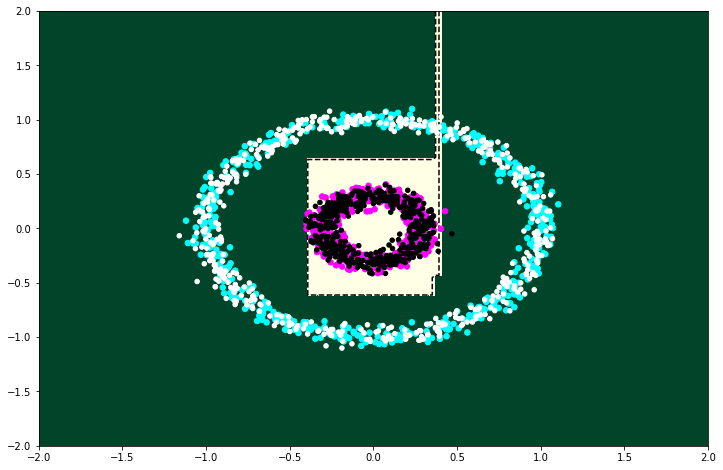

In [43]:
n_t=8
clf=sktr.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0, max_depth=n_t)
clf.fit(X_train,y_train)
acc_test = clf.score(X_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print(clf.tree_.max_depth)
plot_classifier(clf, X_train, y_train, X_test, y_test, 'tree')

---
### 1.f

#### placeholder

In [50]:
kpca = skdc.KernelPCA(n_components=2,kernel="rbf", gamma=5)
kpca = kpca.fit(X_train)
Xkpca_train = kpca.transform(X_train)
Xkpca_test = kpca.transform(X_test)

---
### 1.g

#### placeholder

Test Accuracy = 1.0
1


/home/vlizana/u/machine-learning/v-temp/lib/python3.5/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


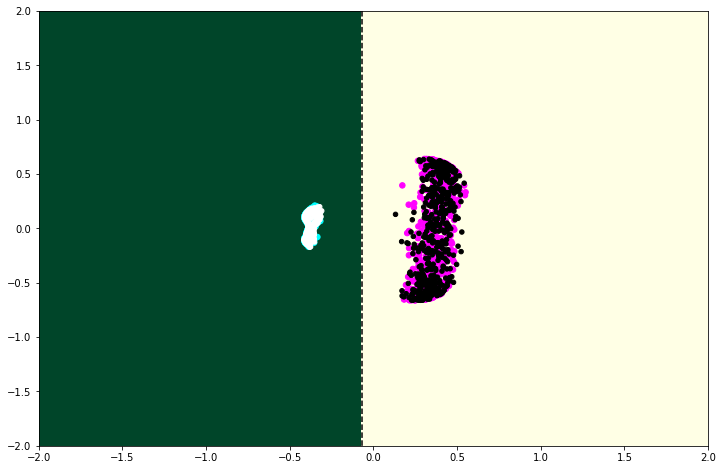

In [51]:
clf = sktr.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0, max_depth=1)
clf.fit(Xkpca_train,y_train)
acc_test = clf.score(Xkpca_test,y_test)
print("Test Accuracy = {}".format(acc_test))
print(clf.tree_.max_depth)
plot_classifier(clf, Xkpca_train, y_train, Xkpca_test, y_test, 'tree')

---

---
## 2.- Bike Sharing

---
### 2.a

#### Datos

In [58]:
dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain, dfval, dftest])
df.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [59]:
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])
df.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


---
### 2.b

#### placeholder

In [91]:
def eval_bikemodel(y_predict, y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def plot_predictions(y_predict, y_true, model=''):
    plt.figure(figsize=(7,7))
    plt.plot(y_true, y_predict, '.')
    plt.plot((0,1000), (0,1000), 'r')
    plt.title('Predictions ' + model)
    plt.xlabel('real y')
    plt.ylabel('predicted y')
    plt.grid()
    plt.show()

     SCORE TEST = 0.7033880538
KAGG EVAL TRAIN = 0.0285162833
 KAGG EVAL TEST = 0.5742388006


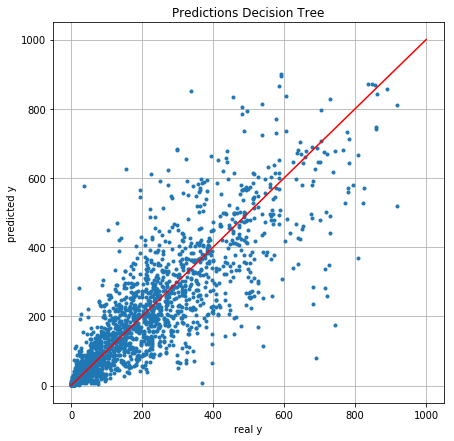

In [92]:
Xdf = df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]
Ydf = df.loc[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = sktr.DecisionTreeRegressor(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("     SCORE TEST = {:>.10f}".format(score_test))

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN = {:>.10f}".format(kagg_train))
print(" KAGG EVAL TEST = {:>.10f}".format(kagg_test))

plot_predictions(Y_test, Y_pred_test, model='Decision Tree')

---
### 2.c

#### placeholder

In [77]:
model = sktr.DecisionTreeRegressor(random_state=0, max_depth=20)
model.fit(X_train, Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val, Y_val)
print("KAGG EVAL VAL = {:>.10f}".format(kagg_val))

KAGG EVAL VAL = 0.5462190412


---
### 2.d

#### placeholder

In [78]:
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek # 0:lunes, 6:domingo
df['cday'] = pd.to_numeric(df['cday'])
Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday']]

---
### 2.e

#### placeholder

In [79]:
dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')

In [94]:
df = pd.concat([dftrain, dfval, dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])

Xdf = df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday']]
Xdf = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday'])
Ydf=df.loc[:,'count']

scalerX = skpp.StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

model = sksvm.SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

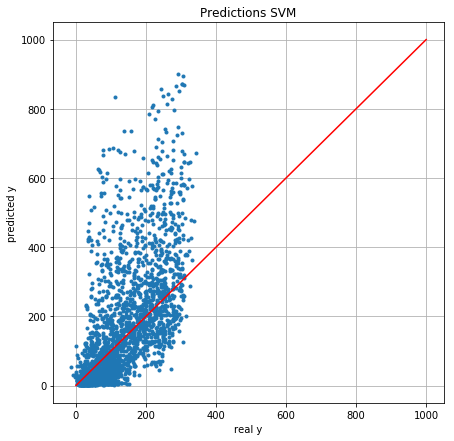

In [95]:
plot_predictions(Y_test, Y_pred_test, model='SVM')

---
### 2.f

#### placeholder

KAGG EVAL TRAIN = nan
  KAGG EVAL VAL = nan


/home/vlizana/u/machine-learning/v-temp/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


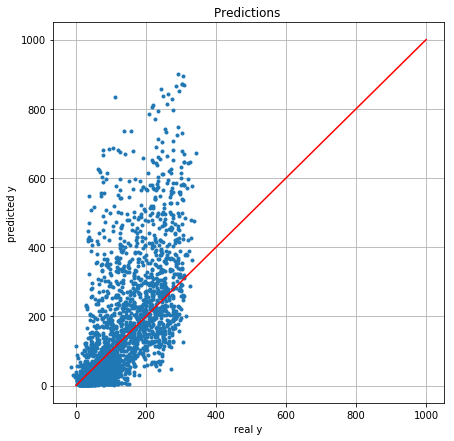

In [100]:
model = sksvm.SVR(C=1,epsilon=0.01)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print("KAGG EVAL TRAIN = {:>.10f}".format(kagg_train))
print("  KAGG EVAL VAL = {:>.10f}".format(kagg_val))
plot_predictions(Y_test, Y_pred_test)

---
### 2.g

#### placeholder

In [ ]:
kf = skms.KFold(n_splits=10)
mse_cv = 0
for train, val in kf.split(Xm):
    model = #define your model
    model.fit(Xm[train], ym[train])
    yhat_val = model.predict(Xm[val])
    ytrue_val = ym[val]
    score_fold = eval_bikemodel(yhat_val,ytrue_val)
    mse_cv += score_fold
mse_cv = mse_cv / 10

---
### 2.h

#### placeholder

---
### 2.i

#### placeholder

---

---
## 3.-

---
### 3.a

#### placeholder

---
### 3.b

#### placeholder

---
### 3.c

#### placeholder

---
### 3.d

#### placeholder

---
### 3.e

#### placeholder

---
### 3.f

#### placeholder

---
### 3.g

#### placeholder

---

---
## 4.-

---
### 4.a

#### placeholder

---
### 4.b

#### placeholder

---
### 4.c

#### placeholder

---
### 4.d

#### placeholder

---
### 4.e

#### placeholder

---
### 4.f

#### placeholder

---

---

---